In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets

# Get MNIST data

In [2]:
def generate_pair_sets():
    data_dir = os.environ.get('PYTORCH_DATA_DIR')
    if data_dir is None:
        data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_features = train_set.train_data.view(-1, 1, 28, 28).float()
    train_target = train_set.train_labels
    train_features = torch.functional.F.avg_pool2d(train_features, kernel_size = 2)

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_features = test_set.test_data.view(-1, 1, 28, 28).float()
    test_target = test_set.test_labels
    test_features = torch.functional.F.avg_pool2d(test_features, kernel_size = 2)

    return train_features, train_target, test_features, test_target

In [3]:
train_features, train_target, test_features, test_target = generate_pair_sets()

C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([60000, 1, 14, 14]) torch.Size([60000])
torch.Size([10000, 1, 14, 14]) torch.Size([10000])


In [5]:
data_size = 1000
train_perm = torch.randperm(train_features.size(0))
idx = train_perm[:data_size]
train_features = train_features[idx].reshape([data_size, train_features.size(2)**2])
train_target = train_target[idx]

test_perm = torch.randperm(test_features.size(0))
idx = test_perm[:data_size]
test_features = test_features[idx].reshape([data_size, test_features.size(2)**2])
test_target = test_target[idx]

In [6]:
def normalize(tensor):
    mean, std = tensor.mean(), tensor.std()
    return tensor.sub_(mean).div_(std)

normalize(train_features)
normalize(test_features)
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([1000, 196]) torch.Size([1000])
torch.Size([1000, 196]) torch.Size([1000])


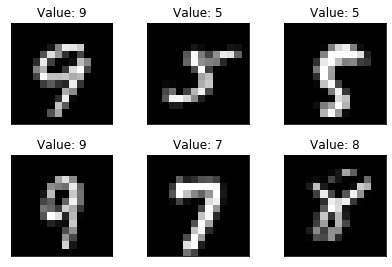

In [7]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(test_features[i].reshape([14, 14]), cmap='gray', interpolation='none')
    plt.title("Value: {}".format(test_target[i]))  
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

# Pytorch model

In [8]:
# device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size) 
        self.ReLU = torch.nn.ReLU() 
        self.softmax = torch.nn.Softmax(dim=1)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc3 = torch.nn.Linear(hidden_size, num_class) 
        self.dropout = torch.nn.Dropout(dropout_p) 
    
    def forward(self, x):
        x = self.dropout(self.ReLU(self.fc1(x)))
        x = self.ReLU(self.fc3(x))
        return x

In [9]:
# function to train each model
def train_model(model_, train_features_, train_target_, criterion_, optimizer_, num_epochs_, batch_size_, learning_rate_decay):
    # getting start time of train to get the train time at the end thanks to "end_time"
    start_time = datetime.datetime.now()
    # list to get train and test errors at each epoch
    train_error = []
    test_error = []
    # train function
    # Learning rate decay can be enabled or disabled than to an input in the function's parameters
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        # using technique of mini batch (size of the batch in the function's parameters)
        for i in range(int(len(train_features_)/batch_size_)):  
            # getting images and labels in right format
            images = train_features_.narrow(0,i*batch_size_,batch_size_)
            labels = train_target_.narrow(0,i*batch_size_,batch_size_)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        if learning_rate_decay:
            scheduler.step()
        # getting train error at each epoch
        train_error.append(test_accuracy(model_, train_features_, train_target_))
        test_error.append(test_accuracy(model_, test_features, test_target))
    # getting end time and training time
    training_time = datetime.datetime.now() - start_time
    print('Training time: {}'.format(training_time))
    print('Loss: {:.4f} on final epoch: {}. Train error: {:.5f}%, Test error: {:.5f}%'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [10]:
def test_accuracy(model_, my_test_features_, my_test_target_):
    outputs = model_(my_test_features_)
    _, predictions = torch.max(outputs.data, 1)
    count_errors = (predictions.long() != my_test_target_.long()).sum().item()
    return count_errors / my_test_features_.size(0) * 100

# Homemade framework

In [11]:
%load_ext autoreload
%autoreload 2
from homemade_framework import framework as NN

In [12]:
def train_homemade_model(model_, num_epochs_, train_features_np_, train_target_np_, batch_size_):
    start_time = datetime.datetime.now()
    # Convert train_target to one hot encoding
    train_target_one_hot = NN.convert_to_one_hot_labels(train_features_np_, train_target_np_)

    NN.print_current_results(0, model_, train_features_np_, train_target_np_, test_features_np, test_target_np, 0, prefix = "Before training: ")
    test_results = []
    for epochs in range(0, num_epochs_):
        loss_sum = 0
        test_results.append(NN.get_inferences(Model, test_features_np))
        for b in range(train_features.shape[0] // batch_size):
            output = model_.forward(train_features_np_[list(range(b * batch_size_, (b+1) * batch_size_))])
            loss = model_.backward(train_target_one_hot[list(range(b * batch_size_, (b+1) * batch_size_))], output)
            loss_sum = loss_sum + loss.item()
        if epochs % 30 == 0:
            NN.print_current_results(epochs + 1, model_, train_features_np_, train_target_np_, test_features_np, test_target_np, loss_sum)

    training_time = datetime.datetime.now() - start_time
    print('\nTraining time: {}'.format(training_time))
    NN.print_current_results(epochs, Model, train_features_np, train_target_np, test_features_np, test_target_np, loss_sum, prefix = "After training: ")

# Models parameters

In [13]:
# number of epoch
num_epochs = 100
# batch size to compute mini-batch
batch_size = 10
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.01
# hidden size
hidden_size = 128
# p dropout
p_dropout = 0
# learning rate decay
LRD = False

# Train pytorch model

In [17]:
model = NeuralNet(input_size, hidden_size, num_class, p_dropout)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
train_error, test_error, train_time = train_model(model, train_features, train_target, criterion, optimizer, num_epochs, batch_size, LRD)

Training time: 0:00:09.570388
Loss: 0.0326 on final epoch: 100. Train error: 0.00000%, Test error: 11.50000%


# Train homemade model

In [18]:
# convert data to numpy array
train_features_np, train_target_np = train_features.numpy(), train_target.numpy()
test_features_np, test_target_np = test_features.numpy(), test_target.numpy()

# Build the model
Model = NN.Sequential([NN.Linear(input_size, hidden_size), NN.LeakyReLU(), NN.Linear(hidden_size, num_class), NN.LeakyReLU()], NN.LossMSE())
# Set the learning rate
Model.set_Lr(learning_rate)
# Print model's parameters
Model.print(print_color=False)

train_homemade_model(Model, num_epochs, train_features_np, train_target_np, batch_size)

Model description: 
	Linear layer shape: [196, 128]
	LeakyReLU activation
	Linear layer shape: [128, 10]
	LeakyReLU activation
	MSE
Before training: Epoch: 0, Train Error: 88.5000%,        Test Error: 88.1000%, Loss  0.0000
Epoch: 1, Train Error: 90.0000%,        Test Error: 88.6000%, Loss  1273.6170
Epoch: 31, Train Error: 1.6000%,        Test Error: 11.8000%, Loss  25.3638
Epoch: 61, Train Error: 1.2000%,        Test Error: 11.7000%, Loss  28.4304
Epoch: 91, Train Error: 0.8000%,        Test Error: 11.8000%, Loss  11.1132

Training time: 0:00:03.054394
After training: Epoch: 99, Train Error: 0.8000%,        Test Error: 11.4000%, Loss  10.4300
